## Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model, tree, neighbors
from sklearn.model_selection import train_test_split
from scipy.interpolate import griddata

## Dataset

### Datenset einlesen

In [2]:
df = pd.read_csv('https://gist.githubusercontent.com/isnteer-sluz/d0844565a69005d57f924746de44def3/raw/4b7aff36859a840d564af2f895564d37fafe7cf9/gistfile1.txt')
df.info()

df['model_year'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          398 non-null    object 
 1   mpg           398 non-null    float64
 2   cylinders     398 non-null    int64  
 3   displacement  398 non-null    float64
 4   horsepower    392 non-null    float64
 5   weight        398 non-null    int64  
 6   acceleration  398 non-null    float64
 7   model_year    398 non-null    int64  
 8   origin        398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


,count
model_year,
73,40
78,36
76,34
82,31
75,30
70,29
79,29
80,29
81,29


### Datenset bereinigen so das man HeatMap erstellen kann.

In [3]:
# Ich brauche den Namen nicht desshalb droppe ich diese Spalte.
df_droped = df.drop('name', axis=1)

# Weil Origin wichtig sein könnte werde ich diese One-Hot Encodieren.
df_droped['origin_encoded'] = pd.factorize(df['origin'])[0]

Überprüfen ob es Funktioniert hat.

In [4]:
df_droped.tail(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,origin_encoded
388,26.0,4,156.0,92.0,2585,14.5,82,usa,0
389,22.0,6,232.0,112.0,2835,14.7,82,usa,0
390,32.0,4,144.0,96.0,2665,13.9,82,japan,1
391,36.0,4,135.0,84.0,2370,13.0,82,usa,0
392,27.0,4,151.0,90.0,2950,17.3,82,usa,0
393,27.0,4,140.0,86.0,2790,15.6,82,usa,0
394,44.0,4,97.0,52.0,2130,24.6,82,europe,2
395,32.0,4,135.0,84.0,2295,11.6,82,usa,0
396,28.0,4,120.0,79.0,2625,18.6,82,usa,0
397,31.0,4,119.0,82.0,2720,19.4,82,usa,0


### Übersicht über die Daten bekommen (HeatMap)

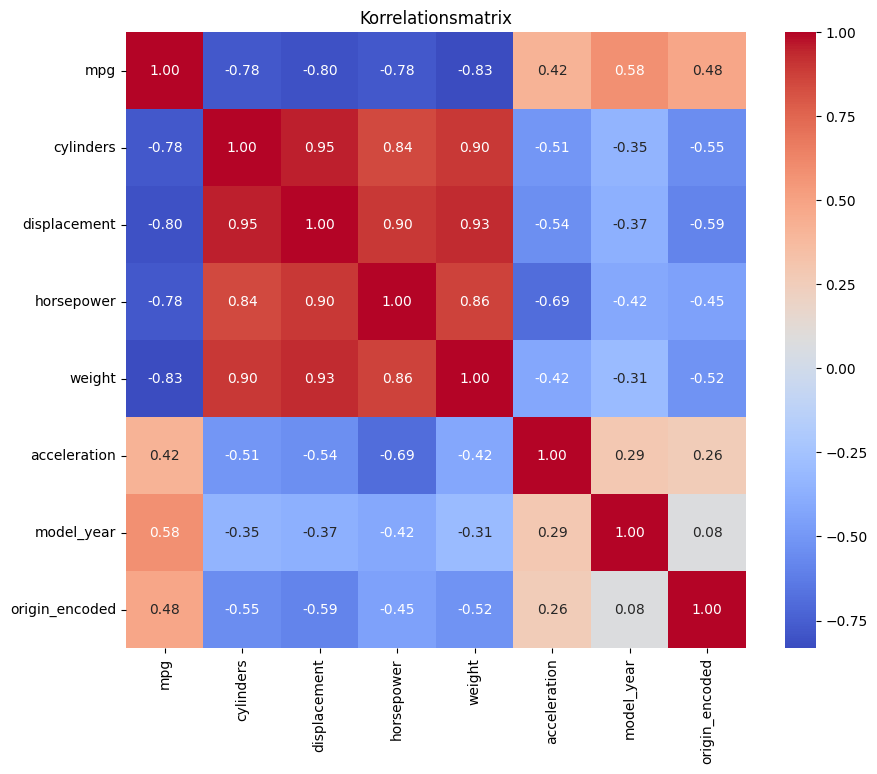

In [5]:
no_text_df = df_droped.drop('origin', axis=1)
no_text_df.head(10)

correlation_matrix = no_text_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korrelationsmatrix')
plt.show()

### Datenset mit unnötigen Werten bereinigen

Durch das Heatmap konnte man Herausfinden das Acceleration, Model_Year, Origin_encoded hat kein grossen einfluss auf mpg

In [6]:
only_relevant_data = no_text_df.drop(columns=['origin_encoded', 'acceleration', 'cylinders', 'weight'], axis=1)
only_relevant_data

,mpg,displacement,horsepower,model_year
0,18.0,307.0,130.0,70
1,15.0,350.0,165.0,70
2,18.0,318.0,150.0,70
3,16.0,304.0,150.0,70
4,17.0,302.0,140.0,70
...,...,...,...,...
393,27.0,140.0,86.0,82
394,44.0,97.0,52.0,82
395,32.0,135.0,84.0,82
396,28.0,120.0,79.0,82


### Datenset bereinigen

Schauen ob Datenset Leere Values hat.

In [7]:
only_relevant_data.isnull().sum()

,0
mpg,0
displacement,0
horsepower,6
model_year,0


In [8]:
only_relevant_data.isna().sum()

,0
mpg,0
displacement,0
horsepower,6
model_year,0


Da es Leere Values hat Löschen wir diese heraus.

In [9]:
# Leere Values Davor

only_relevant_data = only_relevant_data.dropna()

only_relevant_data.isnull().sum()

,0
mpg,0
displacement,0
horsepower,0
model_year,0


### Diagramm Scatterplot

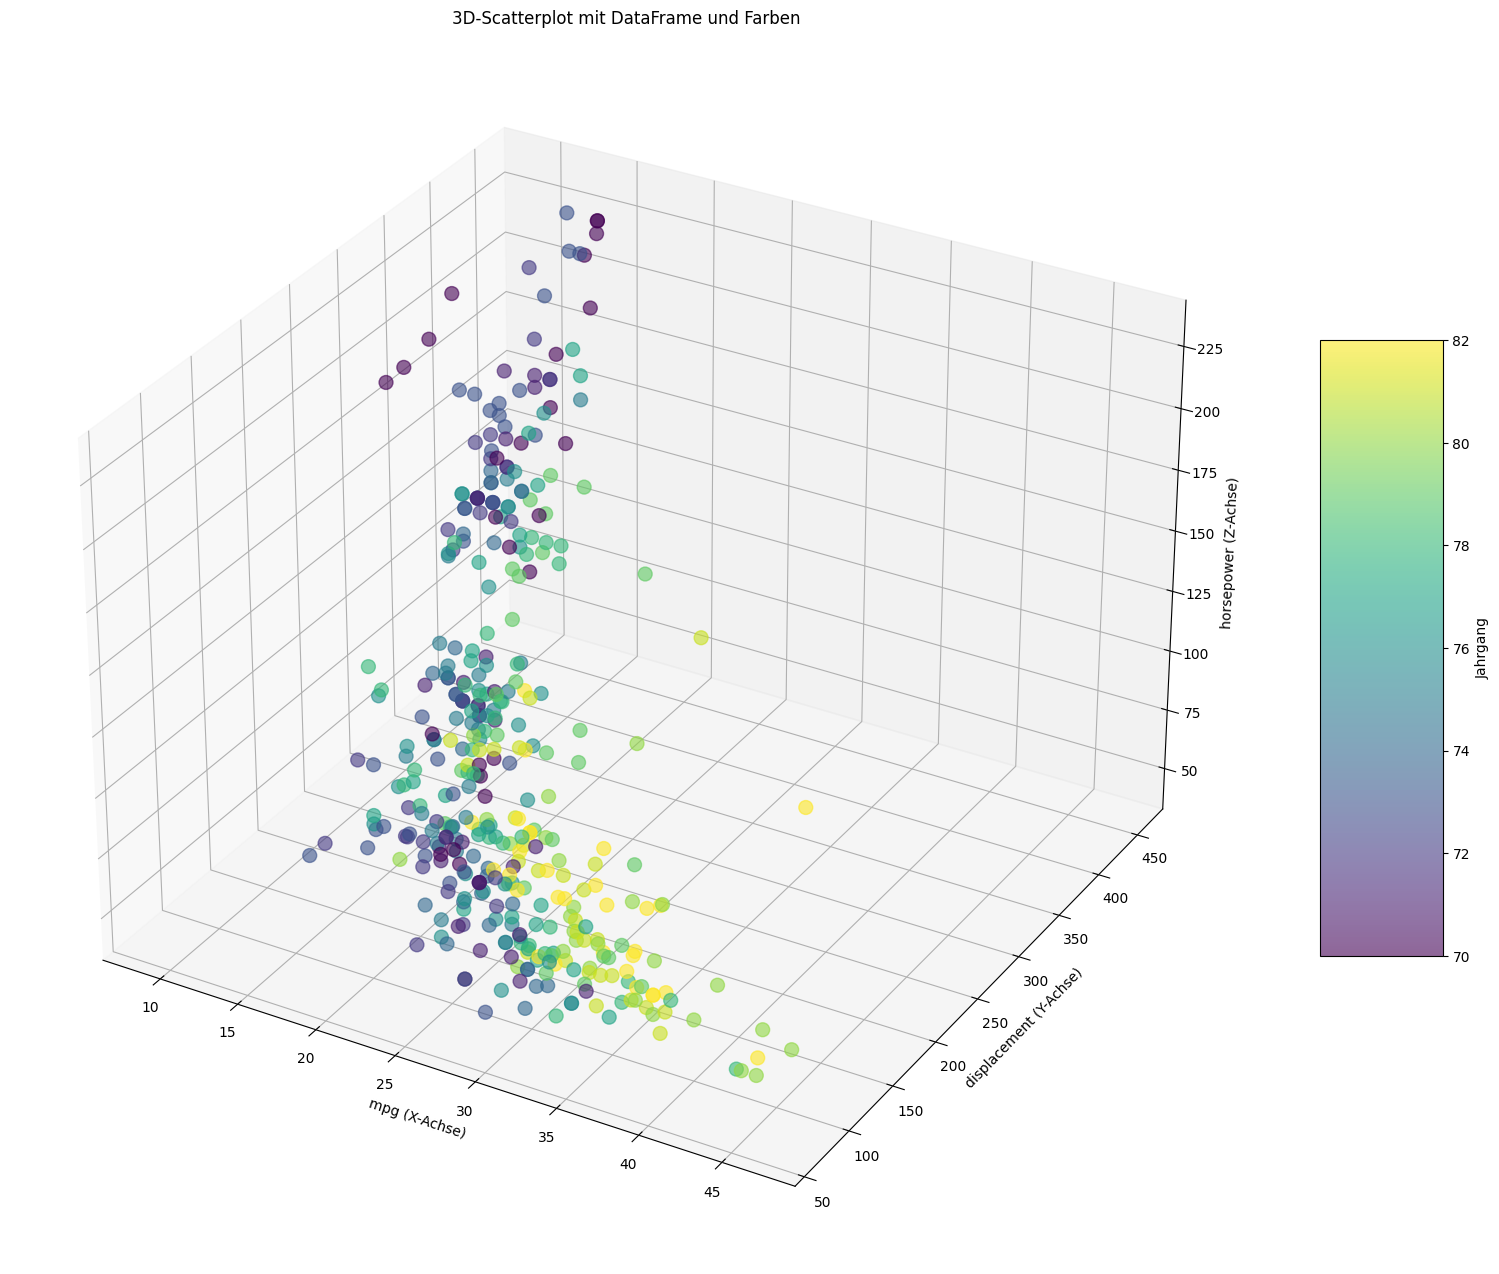

In [10]:
# 3D-Scatterplot mit einem DataFrame erstellen
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111, projection='3d')

# 3D-Scatterplot, x = Variable1, y = Variable2, z = Variable3, Farben basierend auf Jahrgang
scatter = ax.scatter(only_relevant_data['mpg'], only_relevant_data['displacement'], only_relevant_data['horsepower'],
                     c=only_relevant_data['model_year'], cmap='viridis', s=100, alpha=0.6)

# Farbleiste hinzufügen
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Jahrgang')

# Achsentitel
ax.set_xlabel('mpg (X-Achse)')
ax.set_ylabel('displacement (Y-Achse)')
ax.set_zlabel('horsepower (Z-Achse)')

# Titel des Plots
plt.title('3D-Scatterplot mit DataFrame und Farben')

# Plot anzeigen
plt.show()

## Daten Unterteilen (Train und Test)

### X_Train und Y_Train erstellen um zu Trainieren und X_Test und Y_Test erstellen um zu Testen.

In [11]:
X = only_relevant_data[['mpg', 'displacement', 'horsepower']]
Y = only_relevant_data['model_year']

In [12]:
X.tail(10)

,mpg,displacement,horsepower
388,26.0,156.0,92.0
389,22.0,232.0,112.0
390,32.0,144.0,96.0
391,36.0,135.0,84.0
392,27.0,151.0,90.0
393,27.0,140.0,86.0
394,44.0,97.0,52.0
395,32.0,135.0,84.0
396,28.0,120.0,79.0
397,31.0,119.0,82.0


In [13]:
Y.tail(10)

,model_year
388,82
389,82
390,82
391,82
392,82
393,82
394,82
395,82
396,82
397,82


In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Nearest Neighbors Modell

### Modell fitten

In [15]:
kncl = neighbors.KNeighborsClassifier(10, weights="uniform")
kncl.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=10)

### Modell Anwenden

In [16]:
Y_predict = kncl.predict(X_test)

### Modell Anschauen

In [17]:
pd.DataFrame([Y_predict, Y_test]).transpose()

,0,1
0,77,81
1,81,77
2,80,82
3,77,78
4,75,72
...,...,...
74,77,77
75,72,73
76,80,75
77,76,71


### Mesh aus Daten generieren

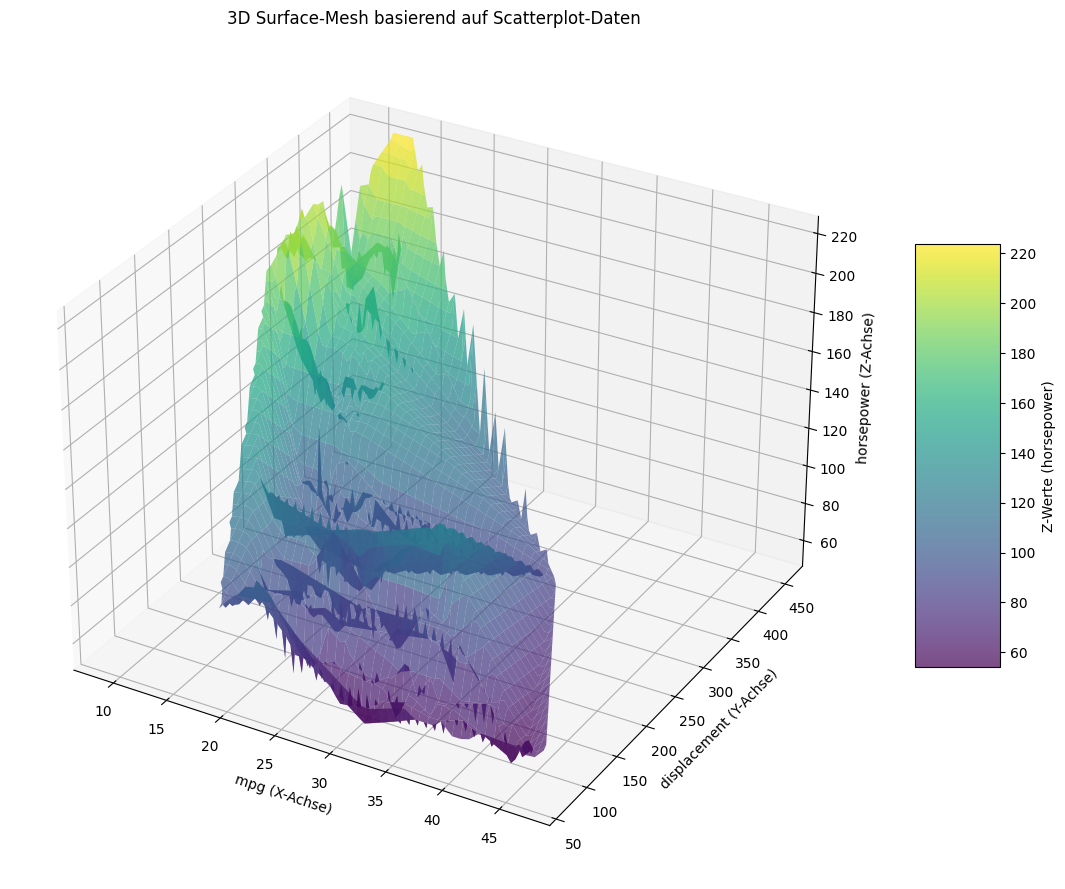

In [18]:
# Beispiel: Wir nehmen die Daten aus deinem Scatterplot
x = only_relevant_data['mpg']
y = only_relevant_data['displacement']
z = only_relevant_data['horsepower']

# Erstelle Gitter für die x- und y-Werte
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpoliere die Z-Werte, um sie ins Gitter einzupassen
zi = griddata((x, y), z, (xi, yi), method='linear')

# 3D-Plot vorbereiten
fig = plt.figure(figsize=(15, 11))
ax = fig.add_subplot(111, projection='3d')

# Erstelle ein Surface-Mesh
surface = ax.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none', alpha=0.7)

# Farbleiste hinzufügen
cbar = fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Z-Werte (horsepower)')

# Achsentitel
ax.set_xlabel('mpg (X-Achse)')
ax.set_ylabel('displacement (Y-Achse)')
ax.set_zlabel('horsepower (Z-Achse)')

# Titel des Plots
plt.title('3D Surface-Mesh basierend auf Scatterplot-Daten')

# Mesh Anzeigen
plt.show()

## Decision Tree Modell

### Modell fitten

In [19]:
TreeClsID = tree.DecisionTreeClassifier(max_depth=5)
TreeClsID.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=5)

### Modell Anwenden

In [20]:
Y_predict = TreeClsID.predict(X_test)

### Modell Anschauen Tabelle

In [21]:
pd.DataFrame([Y_predict, Y_test]).transpose()

,0,1
0,82,81
1,81,77
2,80,82
3,82,78
4,70,72
...,...,...
74,79,77
75,72,73
76,82,75
77,78,71


### Modell Anschauen Grafisch

[Text(0.6041666666666666, 0.9, 'x[0] <= 29.65\ngini = 0.921\nsamples = 313\nvalue = [22, 23, 23, 32, 20, 22, 31, 25, 29, 23, 19, 21\n23]'),
 Text(0.3333333333333333, 0.7, 'x[0] <= 15.25\ngini = 0.909\nsamples = 244\nvalue = [22, 19, 23, 32, 18, 22, 29, 18, 25, 16, 2, 10\n8]'),
 Text(0.46875, 0.8, 'True  '),
 Text(0.16666666666666666, 0.5, 'x[2] <= 185.0\ngini = 0.816\nsamples = 58\nvalue = [10, 6, 10, 18, 5, 4, 4, 1, 0, 0, 0, 0, 0]'),
 Text(0.08333333333333333, 0.3, 'x[2] <= 129.5\ngini = 0.809\nsamples = 46\nvalue = [2, 6, 9, 15, 5, 4, 4, 1, 0, 0, 0, 0, 0]'),
 Text(0.041666666666666664, 0.1, '\n  (...)  \n'),
 Text(0.125, 0.1, '\n  (...)  \n'),
 Text(0.25, 0.3, 'x[0] <= 13.5\ngini = 0.486\nsamples = 12\nvalue = [8, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]'),
 Text(0.20833333333333334, 0.1, '\n  (...)  \n'),
 Text(0.2916666666666667, 0.1, '\n  (...)  \n'),
 Text(0.5, 0.5, 'x[1] <= 130.5\ngini = 0.909\nsamples = 186\nvalue = [12.0, 13.0, 13.0, 14.0, 13.0, 18.0, 25.0, 17.0, 25.0\n16.0, 2.0, 1

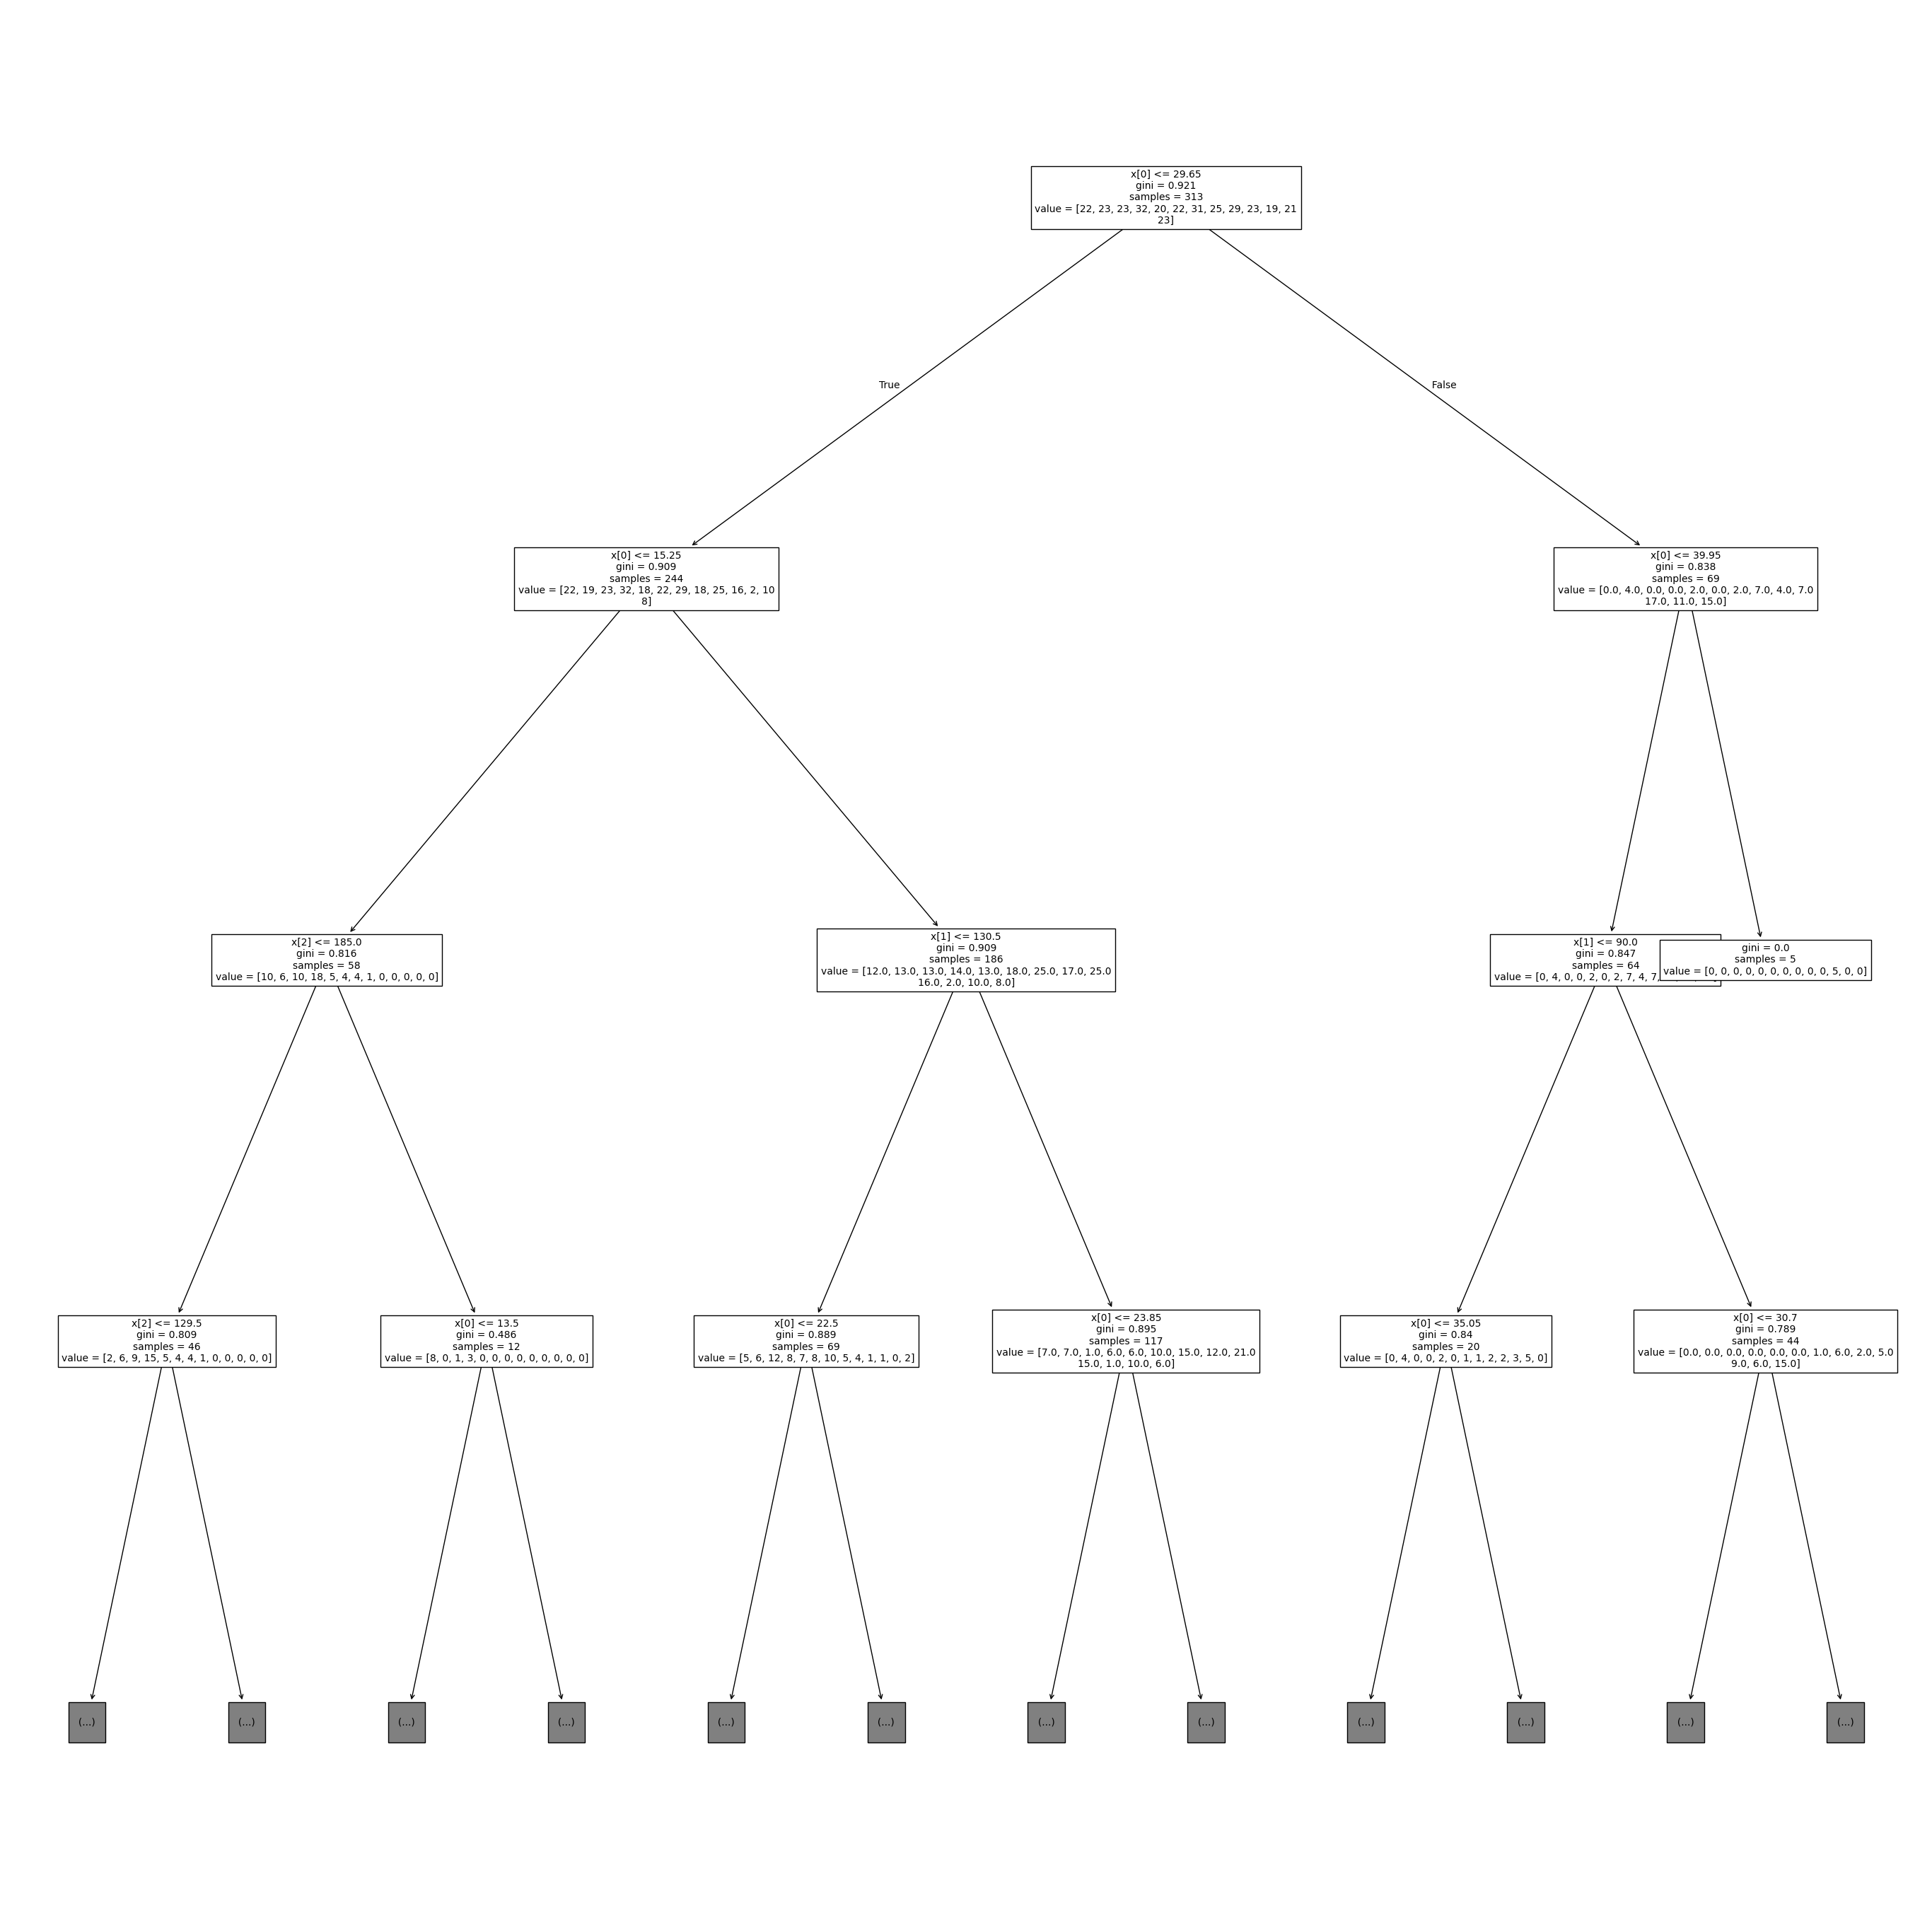

In [23]:
plt.figure(figsize=(35,35))
tree.plot_tree(TreeClsID, max_depth=3, fontsize=10)